# Code zu Lanczos-Verfahren mithilfe von QR-Verfahren

In [130]:
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import block_diag
import time
import matplotlib.pyplot as plt

### Funktionen zum generiern von Matrizen

In [131]:
def gen_hess(n, compl = False):
    if compl:
        a = np.random.rand(n) + np.random.rand(n)*1j
        b = np.random.rand(n-1) + np.random.rand(n-1)*1j
        c = np.random.rand(n-1) + np.random.rand(n-1)*1j
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    else:
        a = np.random.rand(n)
        b = np.random.rand(n-1)
        c = np.random.rand(n-1)
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    

def gen_upper_tri(eig, compl = False):
    n = eig.shape[0]
    if compl:
        return np.triu(np.random.rand(n,n) + np.random.rand(n,n) * 1j, 1) + np.diag(eig)
    else:
        return np.triu(np.random.rand(n,n),1) + np.diag(eig)
    

def gen_hermite(eig, compl = False):
    n = eig.shape[0]
    B = unitary_group.rvs(n)
    return B.T.conj()@np.diag(eig)@B


def gen_rand_mat(eig, compl = False):
    n = eig.shape[0]
    if compl:
        B = np.random.rand(n,n) + np.random.rand(n,n)*compl*1j
    else:
        B = np.random.rand(n,n)
    return np.linalg.inv(B)@np.diag(eig)@B



#print(gen_hess(5))
#print(gen_upper_tri(np.array([1,2,3]), True))
#print(gen_hermite(np.array([1,2,3,4])))
#print(gen_rand_mat(np.array([1,2,7,4])))



### Verfahren implementiert

In [132]:
def QR_simple(A,tol = 1e-6):
    count = 0
    while abs(A[1,0]) > tol:
        Q,R = np.linalg.qr(A)
        A = R@Q
        count +=1
    return A, sorted(np.diag(A)) ,count



def QR_shift(A,tol=1e-6):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol:
            rho = A[i,i]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count +=1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_shift2(A,tol=1e-6):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_hesse(A,tol=1e-6):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):
            t = A[i+1,i]/abs(A[i,i])
            root = (1+abs(t)**2)**(1/2)
            c = A[i,i]/(abs(A[i,i])*root)
            s = t/root
        else:
            t = A[i,i]/abs(A[i+1,i])
            root = (1+abs(t)**2)**(1/2)
            s = A[i+1,i]/(abs(A[i+1,i])*root)
            c = t/root
            
        M = np.array([[c.conj(), s.conj()], [-s, c]])
        G = block_diag(np.eye(i,i), M, np.eye(n-i-2, n-i-2))
        Q = G@Q
        for j in range(i, n):
            temp_1 = A[i,j]
            A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]
            A[i+1,j] = -s*temp_1 + c*A[i+1,j]
    return Q.T.conj(), A



def lanczos(A,k = 0):
    n = A.shape[1]
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    gam = [v[0].T.conj()@A@v[0]]
    w = (A - gam[0]*np.identity(n))@v[0]
    delta = [np.linalg.norm(w)]
    i = 0
    while delta[i] > 1e-12 and i<k-1:
        v.append(w/delta[i])
        i +=1
        gam.append(v[i].T.conj()@A@v[i])
        w = (A - gam[i]*np.identity(n))@v[i] - delta[i-1]*v[i-1]
        delta.append(np.linalg.norm(w))
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)
    return QR_hesse(T)



### Testing

In [190]:
def error(eig_1, eig_2):
    return np.linalg.norm(eig_1 - eig_2)


def runtime(f,A):
    start = time.time()
    f(A)
    end = time.time()
    return end - start

def runtime_error(f,A):
    start = time.time()
    S = f(A)
    end = time.time()
    return end - start, S

def runtime_error_lanczos(f,A,k):
    start = time.time()
    S = f(A,k)
    end = time.time()
    return end - start, S

def testing(f, n_1, n_2):
    n_array = np.array([i for i in range(n_1,n_2)])
    time_array = []
    error_array = []
    for n in n_array:
        eigv = np.sort(50*np.random.rand(n)-25)
        A = gen_hermite(eigv)
        t, A = runtime_error(f,A)
        err = error(A[1], eigv)
        time_array.append(t)
        error_array.append(err)
    plt.plot(n_array, time_array, label = "runtime")
    #plt.plot(n_array, error_array, 'x', label = "errors")
    plt.legend()
    plt.show()

    
def testing_lanczos(f,k, n_1, n_2):
    n_array = np.array([i for i in range(n_1,n_2)])
    time_array = []
    error_array = []
    for n in n_array:
        eigv = np.sort(50*np.random.rand(n)-25)
        A = gen_hermite(eigv)
        t, A = runtime_error_lanczos(f,A,k)
        err = error(A[1][0], eigv[0])
        time_array.append(t)
        error_array.append(err)
    plt.plot(n_array, time_array, label = "runtime lanczos")
    #plt.plot(n_array, error_array, 'x', label = "errors")
    plt.legend()
    plt.show()

# ------- testing starts here -------

n = 50
eigv = np.sort(50*np.random.rand(n)-25)
A = gen_hermite(eigv)

#print(eigv)
#print(np.round(QR_simple(A)[1],3))
#print(np.round(QR_shift(A)[1],3))
#print(np.round(QR_shift2(A)[1],3))
#print(np.round(lanczos(A)[1],3))


#print(error(QR_simple(A)[1], eigv))
#print(error(QR_shift(A)[1], eigv))
#print(error(QR_shift2(A)[1], eigv))
#print(error(lanczos(A)[1], eigv))


#print(runtime(QR_simple, A))
#print(runtime(QR_shift, A))
#print(runtime(QR_shift2, A))
print(runtime_error_lanczos(lanczos, A, 10)[0])

0.014960050582885742


<IPython.core.display.Javascript object>


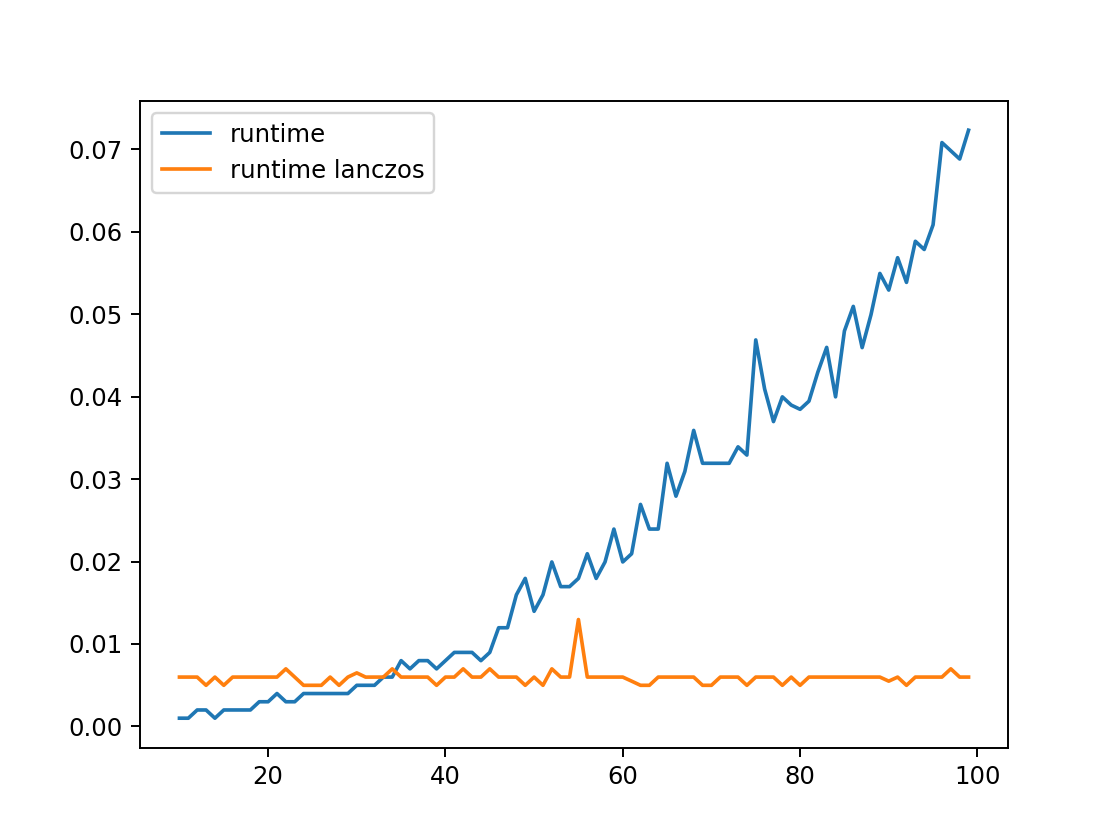

In [191]:
%matplotlib notebook

testing(QR_shift2, 10, 100)

testing_lanczos(lanczos, 7, 10, 100)